# Predict next month product demand based on historical demands

# This is Time Series Analysis. We need to import all the libraries to do our time series predictive analysis. 

In [1]:
# Just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
sns.set()
import plotly as py
# Import dependencies
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special
# Configure Plotly to be rendered inline in the notebook.
py.offline.init_notebook_mode(connected=True)
import itertools
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Read data set from manufacturer and explore the features

In [2]:
df = pd.read_csv('HPD2.csv', parse_dates=['Date'])
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_1507,Whse_C,Category_019,2011-09-02,1250
1,Product_0608,Whse_C,Category_001,2011-09-27,5
2,Product_1933,Whse_C,Category_001,2011-09-27,23
3,Product_0875,Whse_C,Category_023,2011-09-30,5450
4,Product_0642,Whse_C,Category_019,2011-10-31,3


In [3]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In [4]:
df.nunique()

Product_Code        2160
Warehouse              4
Product_Category      33
Date                1712
Order_Demand        3282
dtype: int64

# 1. Product Code (categorical): 2160 products
# 2. Warehouse (categorical): 4 warehouses
# 3. Product category (categorical): 33 categories¶
# 4. Date (date): demand fulfillment date
# 5. Order demanded (integer): target demand value

In [5]:
df.Product_Code.unique()

array(['Product_1507', 'Product_0608', 'Product_1933', ...,
       'Product_0465', 'Product_1013', 'Product_0853'], dtype=object)

In [6]:
df.Product_Category.unique()

array(['Category_019', 'Category_001', 'Category_023', 'Category_028',
       'Category_006', 'Category_007', 'Category_021', 'Category_004',
       'Category_015', 'Category_024', 'Category_030', 'Category_026',
       'Category_003', 'Category_018', 'Category_009', 'Category_032',
       'Category_011', 'Category_020', 'Category_013', 'Category_005',
       'Category_022', 'Category_031', 'Category_010', 'Category_033',
       'Category_017', 'Category_008', 'Category_029', 'Category_025',
       'Category_012', 'Category_014', 'Category_002', 'Category_027',
       'Category_016'], dtype=object)

In [7]:
df['Product_Category'].value_counts()

Category_019    445251
Category_005    100711
Category_001     96841
Category_007     81159
Category_021     50938
Category_006     35098
Category_028     28923
Category_011     22973
Category_015     22437
Category_024     20371
Category_009     19253
Category_026     14508
Category_030     12958
Category_032      9240
Category_022      8516
Category_023      7826
Category_018      5150
Category_003      4111
Category_013      3658
Category_020      3432
Category_031      2209
Category_033      1833
Category_008      1540
Category_012      1113
Category_010       945
Category_029       645
Category_017       602
Category_004       325
Category_002        76
Category_016        37
Category_025        35
Category_014        26
Category_027        21
Name: Product_Category, dtype: int64

# Group by product category and make it in order by count. We want to get the order demand for top three categories.


In [8]:
Cat_fltr = df.groupby(['Product_Category']).size().reset_index(name='Cat_count').sort_values(['Cat_count'],ascending=False)
Cat_fltr.head(10)

,Product_Category,Cat_count
18,Category_019,445251
4,Category_005,100711
0,Category_001,96841
6,Category_007,81159
20,Category_021,50938
5,Category_006,35098
27,Category_028,28923
10,Category_011,22973
14,Category_015,22437
23,Category_024,20371


# Let's look at the highest product code in demand as well.

In [10]:
Code_fltr = df.groupby(['Product_Code']).size().reset_index(name='Code_count').sort_values(['Code_count'],ascending=False)
Code_fltr.head(10)

,Product_Code,Code_count
1348,Product_1359,16861
1284,Product_1295,10443
1367,Product_1378,9652
619,Product_0620,9367
1275,Product_1286,8790
1371,Product_1382,8520
1442,Product_1453,8385
1283,Product_1294,8313
1366,Product_1377,7761
1276,Product_1287,7727


# Categories  1, 5 and 19 are with top three counts. We are using Category_001 as an example to predict next month product category demand

# Let's make our Category_001 as a separate data frame and start preparing it for our forecast

In [11]:
Category_001 = df.loc[df['Product_Category'] == 'Category_001'] #.sort_values(['Date'],ascending=False)
Category_001.describe()

,Order_Demand
count,96841.000000
mean,17.997914
std,53.364740
min,1.000000
25%,1.000000
50%,5.000000
75%,15.000000
max,2075.000000


# Look at the available start and end date stamps

In [12]:
Category_001['Date'].min(), Category_001['Date'].max()

(Timestamp('2011-09-27 00:00:00'), Timestamp('2017-01-06 00:00:00'))

# Data Preprocessing - droping columns

In [13]:
cols = [ 'Product_Code', 'Warehouse', 'Product_Category']
Category_001.drop(cols, axis=1, inplace=True)
Category_001 = Category_001.sort_values('Date')
Category_001.isnull().sum()

Date            0
Order_Demand    0
dtype: int64

# We have daily data. We want to aggregate demand for Category 001 by year and month - grouping by month. 

In [14]:
Category_001[['year','month']] = Category_001.Date.apply(lambda x: pd.Series(x.strftime("%Y,%m").split(",")))
Category_001 = Category_001.groupby(['year', 'month', ])[['Order_Demand']].sum().reset_index()
Category_001=Category_001[['year', 'month', 'Order_Demand']]
Category_001

,year,month,Order_Demand
0,2011,09,28
1,2011,12,957
2,2012,01,22172
3,2012,02,25866
4,2012,03,30002
5,2012,04,20960
6,2012,05,20391
7,2012,06,21214
8,2012,07,20313
9,2012,08,18159


# Create pivot table to look at monthly product demand

In [15]:
Category_001_pivot = Category_001.pivot('month', 'year', 'Order_Demand')
Category_001_pivot

year,2011,2012,2013,2014,2015,2016,2017
month,,,,,,,
01,NaN,22172.0,22281.0,26276.0,35569.0,31214.0,29.0
02,NaN,25866.0,29030.0,26665.0,37465.0,33834.0,NaN
03,NaN,30002.0,26776.0,36264.0,34587.0,39711.0,NaN
04,NaN,20960.0,24464.0,25970.0,30803.0,32248.0,NaN
05,NaN,20391.0,21452.0,28438.0,25452.0,26485.0,NaN
06,NaN,21214.0,22989.0,29207.0,36159.0,35364.0,NaN
07,NaN,20313.0,30267.0,32801.0,34183.0,31433.0,NaN
08,NaN,18159.0,24993.0,28950.0,29797.0,26377.0,NaN
09,28.0,19864.0,27373.0,30246.0,27524.0,33249.0,NaN


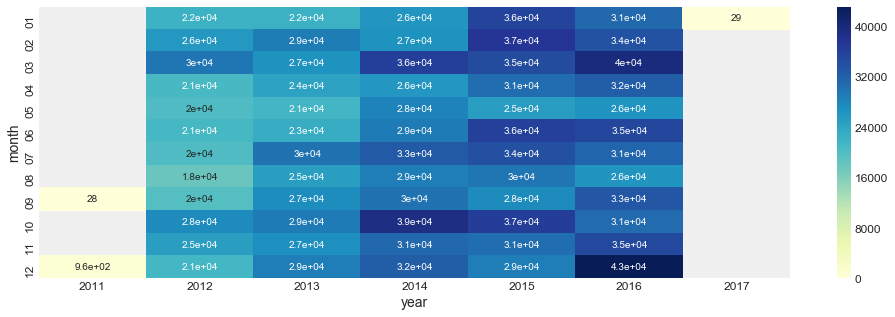

In [16]:
plt.figure(figsize=(15, 5))
sns.heatmap(Category_001_pivot, annot = True, cmap = "YlGnBu")

# Indexing with Time Series Data and drop random dates in 2011 and 2017. Those months have only a few days of data and will not be used in our forecast 

In [17]:
Category_001 = Category_001.drop(Category_001.index[[0,1]])
Category_001 = Category_001.drop(Category_001.index[[-1]])
Category_001

,year,month,Order_Demand
2,2012,01,22172
3,2012,02,25866
4,2012,03,30002
5,2012,04,20960
6,2012,05,20391
7,2012,06,21214
8,2012,07,20313
9,2012,08,18159
10,2012,09,19864
11,2012,10,27648


# Combine dates and create datetime index to prepare Category_001 dataset for time series forecast

In [30]:
Category_001['Timestamp'] = pd.date_range('20120131', periods = 60, freq = 'M')


In [31]:
y = Category_001.loc[:, ('Order_Demand')]
y.head(10), 


(Timestamp
 2012-01-31    22172
 2012-02-29    25866
 2012-03-31    30002
 2012-04-30    20960
 2012-05-31    20391
 2012-06-30    21214
 2012-07-31    20313
 2012-08-31    18159
 2012-09-30    19864
 2012-10-31    27648
 Name: Order_Demand, dtype: int64,)

In [32]:
Category_001 = Category_001.set_index('Timestamp')
Category_001.index

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
               '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
      

# Visualizing Order Demand for Category_001

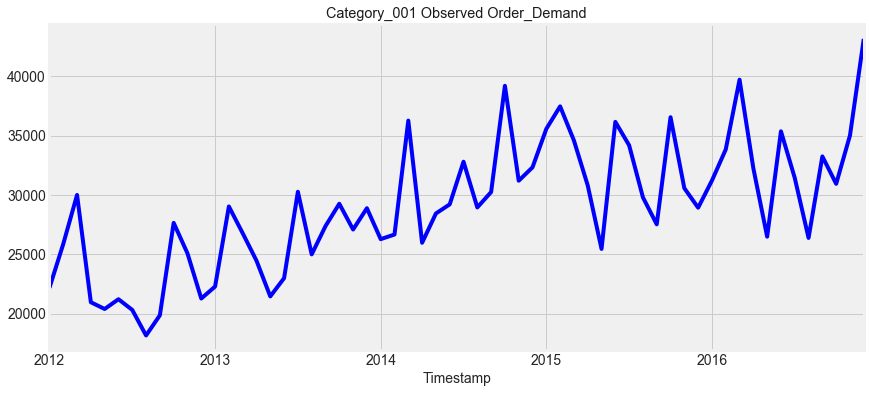

In [35]:
y.plot(figsize=(13,6), title= 'Category_001 Observed Order_Demand', fontsize=14, color="Blue")
plt.show()

# Split data for each category into train and test sets - 80/20%

In [40]:
#train, test = y[:48], y[:12]
train = y.loc['2012-01-31':'2015-12-31']
test = y.loc['2015-12-31':]
train.shape, test.shape


((48,), (13,))

In [41]:
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
test.index = pd.DatetimeIndex(test.index.values, freq=test.index.inferred_freq)

# Visualize train and test sets

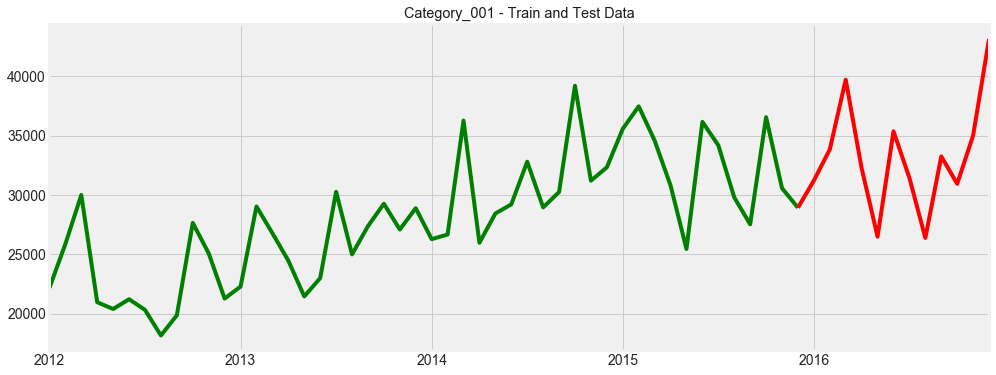

In [42]:
train.plot(figsize=(15,6), title= 'Category_001 - Train and Test Data', fontsize=12,color="Green")
test.plot(figsize=(15,6), fontsize=14, color="Red")
plt.show();

# Use simple smoothing

In [43]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

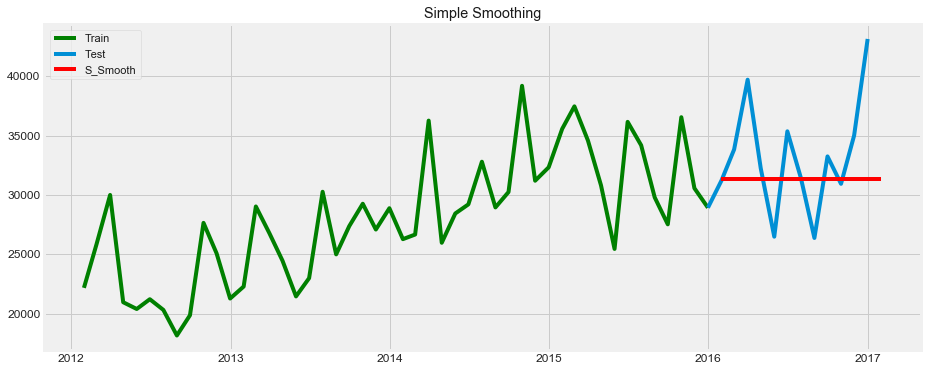

In [44]:
#simple smoothing
s_avg = test.copy()
fit_s = SimpleExpSmoothing(train).fit(smoothing_level=0.2,optimized=False)
s_avg['S_Smooth'] = fit_s.forecast(len(test))
plt.figure(figsize=(14,6))
plt.plot(train, label='Train',color="Green")
plt.plot(test, label='Test')
plt.plot(s_avg['S_Smooth'], label='S_Smooth',color="Red")
plt.title("Simple Smoothing")
plt.legend(loc='best')
plt.show()

In [45]:
import math
from sklearn.metrics import mean_squared_error

SRMS = math.sqrt(mean_squared_error(test, s_avg.S_Smooth))
print(SRMS)

4828.45913163672


# Use exponential smoothing

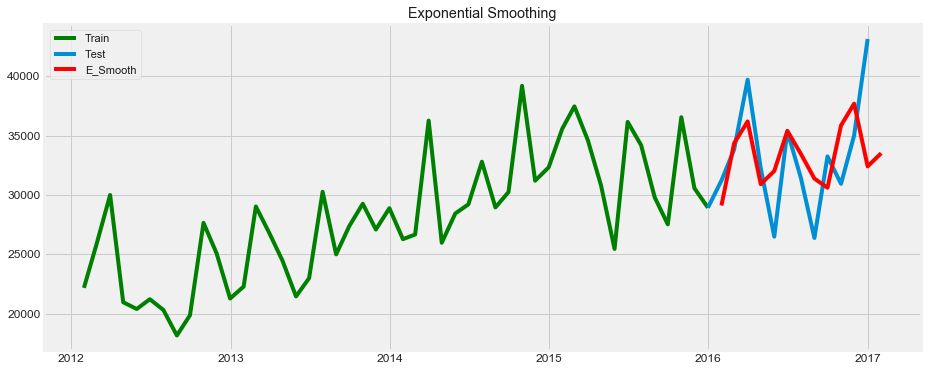

In [46]:
# Exponential Smoothing
exp_avg = test.copy()
fit_e = ExponentialSmoothing(train, seasonal_periods=8 ,trend='additive', seasonal='additive',).fit()
exp_avg['E_Smooth'] = fit_e.forecast(len(test))
plt.figure(figsize=(14,6))
plt.plot( train, label='Train',color="Green")
plt.plot(test, label='Test')
plt.plot(exp_avg['E_Smooth'], label='E_Smooth',color="Red")
plt.legend(loc='best')
plt.title("Exponential Smoothing");
plt.show()

In [47]:
ERMS = math.sqrt(mean_squared_error(test, exp_avg.E_Smooth))
print(ERMS)

5157.288640046792


# Time-series decomposition plot

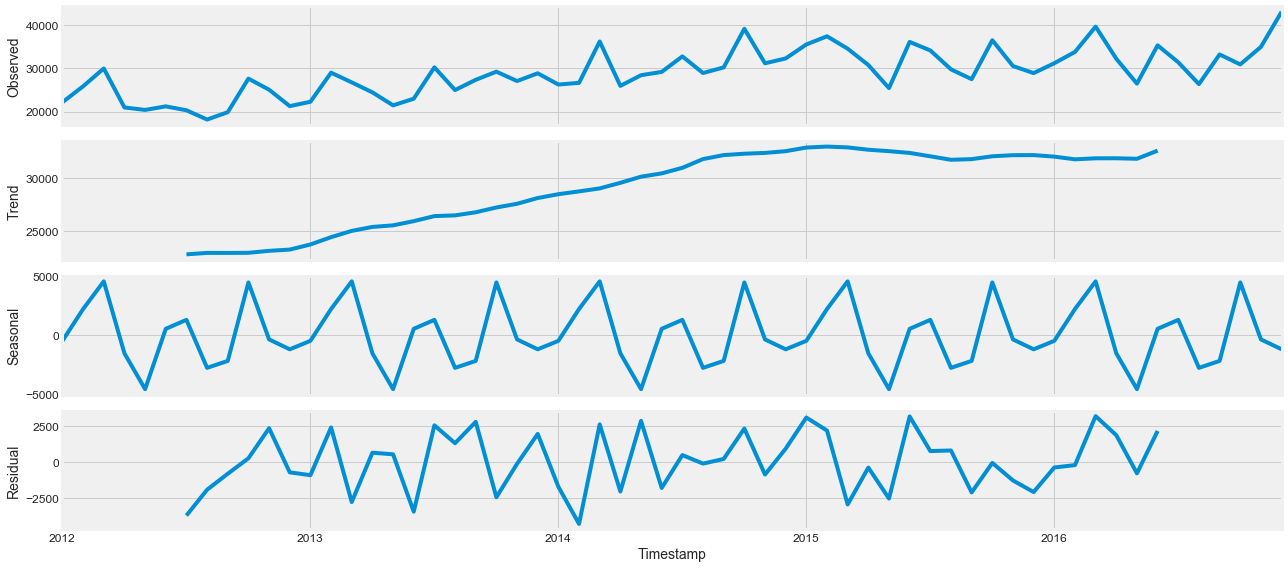

In [48]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
res = sm.tsa.seasonal_decompose(y.interpolate(), model='additive')
resplot = res.plot()
resplot.savefig('Seasonal_Decompose.png', dpi=150)

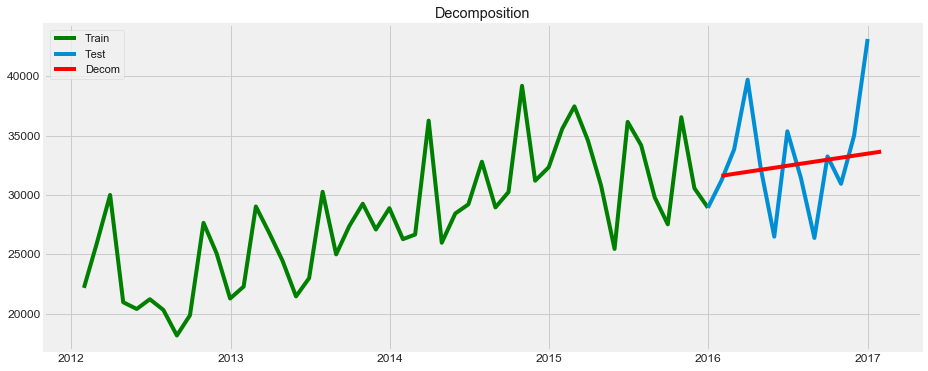

In [49]:
decom_avg = test.copy()
fit_d = Holt(train).fit(smoothing_level = 0.3, smoothing_slope = 0.01)
decom_avg['Decomp'] = fit_d.forecast(len(test))
plt.figure(figsize=(14,6))
plt.plot(train, label='Train',color="Green")
plt.plot(test, label='Test')
plt.plot(decom_avg['Decomp'], label='Decom',color="Red")
plt.legend(loc='best')
plt.title("Decomposition");
plt.show()

In [50]:
DRMS = math.sqrt(mean_squared_error(test, decom_avg.Decomp))
print(DRMS)

4431.645673727458


# Use Holt-Winters Method

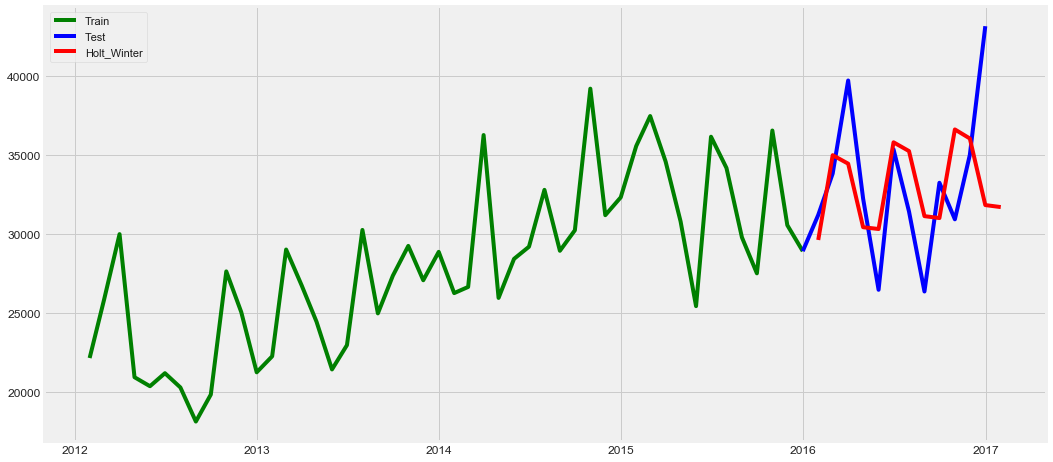

In [51]:
hw_avg = test.copy()
fit_hw = ExponentialSmoothing(train , seasonal_periods=4 ,trend='add', seasonal='mul',).fit()
hw_avg['Holt_Winter'] = fit_hw.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train, label='Train', color="Green")
plt.plot(test, label='Test', color="Blue")
plt.plot(hw_avg['Holt_Winter'], label='Holt_Winter', color="Red")
plt.legend(loc='best')
plt.show()

In [52]:
HRMS = math.sqrt(mean_squared_error(test, hw_avg.Holt_Winter))
print(HRMS)

5488.049450154053


# Run ARIMA model

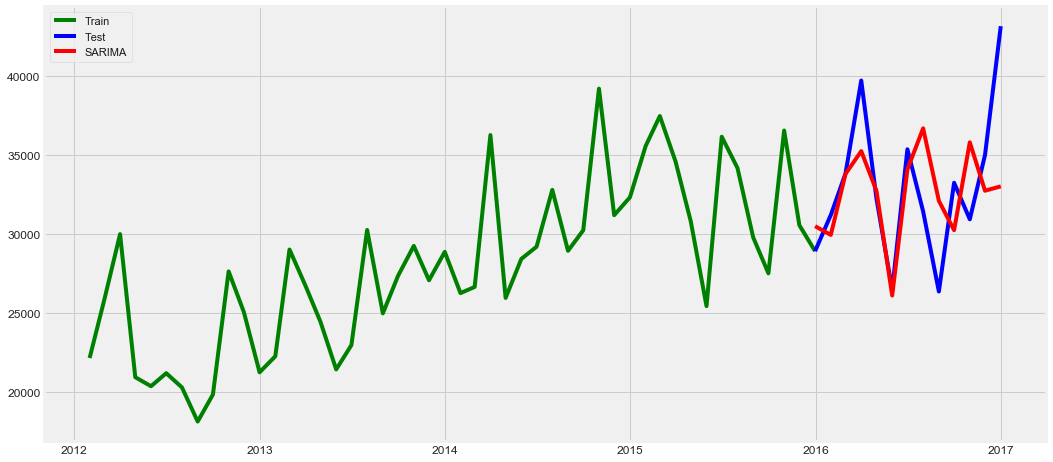

In [53]:
arima_avg = test.copy()
fit_arima = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 4),seasonal_order=(0,1,1,6)).fit()
arima_avg['SARIMA'] = fit_arima.predict(start="2015-12-31", end="2016-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train, label='Train', color="Green")
plt.plot(test, label='Test', color="Blue")
plt.plot(arima_avg['SARIMA'], label='SARIMA', color="Red")
plt.legend(loc='best')
plt.show()

In [54]:
ARMS = math.sqrt(mean_squared_error(test, arima_avg.SARIMA))
print(ARMS)

4176.116086457422


# Re-run ARIMA model with diagnostics and visualize next month forecast for Category_001

# Seasonal ARIMA models are denoted with the notation parameters (p, d, q) and accountable for data seasonality, trend, and noise :

In [55]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


# Find the optimal set of parameters that yields the best performance for the  model

In [56]:
minn=10000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            demand=param,
                                            seasonal_demand=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if float(results.aic)<minn:
                minn=float(results.aic)
                paramm=param
                param_seasonall=param_seasonal
        except:
            continue
print('lowest AIC value is ')
print('ARIMA{}x{}12 - AIC:{}'.format(paramm, param_seasonall, minn))

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1176.4726752171937


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/

ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1176.4726752171937


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/

ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1176.4726752171937


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/

ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1176.4726752171937


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/

ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1176.4726752171937


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/

ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1176.4726752171937


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1176.4726752171937
lowest AIC value is 
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1176.4726752171937


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/

# Fit seasonal ARIMA model

In [74]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 8),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0978      0.324     -0.302      0.763      -0.732       0.536
ma.L1         -0.8501      0.146     -5.807      0.000      -1.137      -0.563
ar.S.L8       -0.7693      0.130     -5.913      0.000      -1.024      -0.514
ma.S.L8        1.0299      0.165      6.254      0.000       0.707       1.353
sigma2      2.438e+07   1.24e-09   1.97e+16      0.000    2.44e+07    2.44e+07


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



# Plot diagnostics to investigate unusual model behavior 

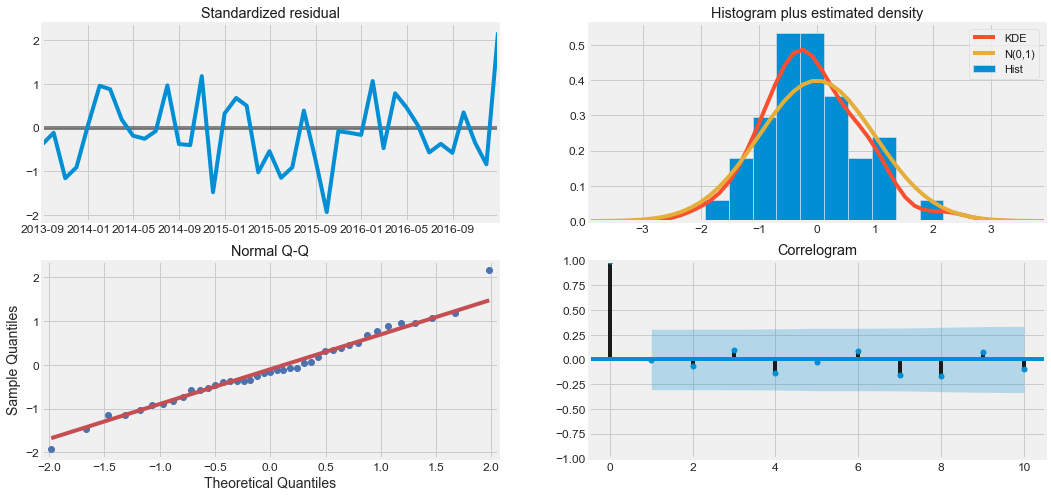

In [75]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validate the accuracy of product demand forecast looking at predicted mean for test set of data 

            lower Order_Demand  upper Order_Demand
2015-12-31        19819.102839        39706.706084
2016-01-31        15829.223207        35755.187275
2016-02-29        26224.346776        46215.286903
2016-03-31        25758.927988        45674.908987
2016-04-30        19940.519243        39827.552886
2016-05-31        16294.212596        36169.291697
2016-06-30        28292.328787        48162.317140
2016-07-31        23370.026203        43238.772969
2016-08-31        19355.235190        39227.908793
2016-09-30        21515.386877        41427.605825
2016-10-31        22729.658379        42696.570111
2016-11-30        29309.077017        49202.839319
2016-12-31        22168.960434        42037.502965


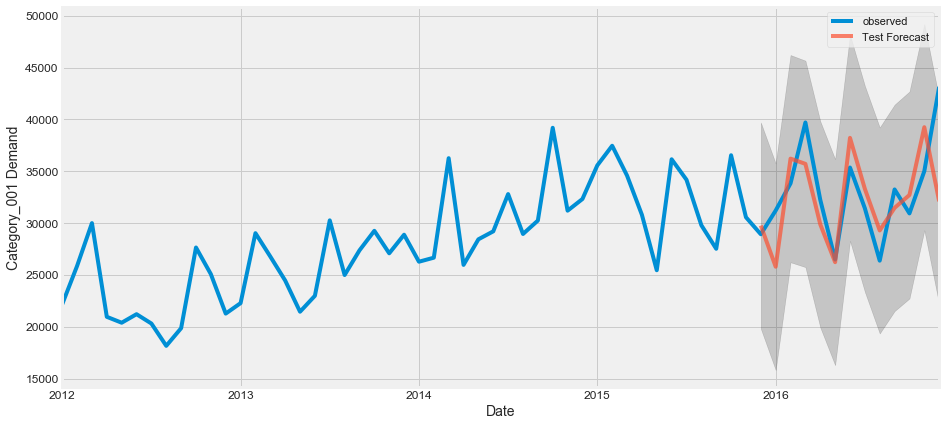

In [76]:
pred = results.get_prediction(start=pd.to_datetime('2015-12-31'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Test Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Category_001 Demand')
plt.legend()
plt.show()

In [77]:
y_forecasted = pred.predicted_mean
print(y_forecasted)

2015-12-31    29762.904461
2016-01-31    25792.205241
2016-02-29    36219.816839
2016-03-31    35716.918487
2016-04-30    29884.036064
2016-05-31    26231.752147
2016-06-30    38227.322964
2016-07-31    33304.399586
2016-08-31    29291.571991
2016-09-30    31471.496351
2016-10-31    32713.114245
2016-11-30    39255.958168
2016-12-31    32103.231699
Freq: M, dtype: float64


# Visualizing one year future product demand forecast 

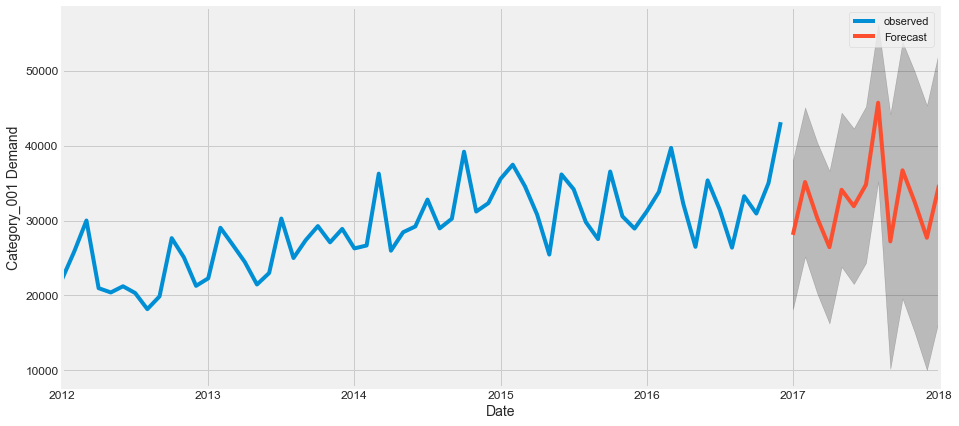

            lower Order_Demand  upper Order_Demand
2017-01-31        18157.163461        38016.228989
2017-02-28        25191.527356        45106.887733
2017-03-31        20251.812689        40414.803242
2017-04-30        16249.325422        36624.483432
2017-05-31        23810.955065        44405.686484
2017-06-30        21524.895135        42305.583019
2017-07-31        24342.209713        45244.178239
2017-08-31        35230.339349        56254.376940
2017-09-30        10203.227870        44226.623992
2017-10-31        19580.096377        53846.396461
2017-11-30        15061.022875        49892.202690
2017-12-31        10025.266009        45370.777135
2018-01-31        16826.297380        52680.607947


In [81]:
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Category_001 Demand')
plt.legend()
plt.show()
print(pred_ci)
print(pred_uc)

# Our Category_001 predicted demand in January 2017 

In [62]:
pred_uc.predicted_mean[0:1]

2017-01-31    32145.745256
Freq: M, dtype: float64

# Root Mean Square Error Comparison Plot

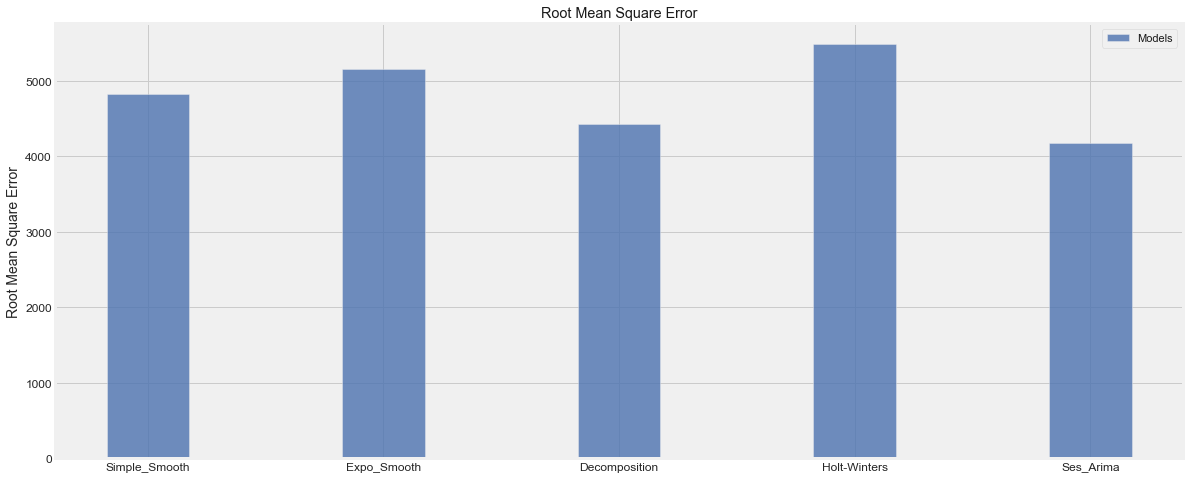

In [63]:
# create groups for
n_groups = 5
MSE = (SRMS, ERMS, DRMS, HRMS, ARMS)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
 
rects2 = plt.bar(index + bar_width, MSE, bar_width, alpha=opacity, color='b', label='Models')
 
plt.ylabel('Root Mean Square Error')
plt.title('Root Mean Square Error')
plt.xticks(index + bar_width, ('Simple_Smooth', 'Expo_Smooth', 'Decomposition', 'Holt-Winters', 'Ses_Arima'))
plt.legend()

# Our models predict reasonably well. Seasonal Arima shows lowest Root Mean Square Error.